In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Retrieve chart from TV

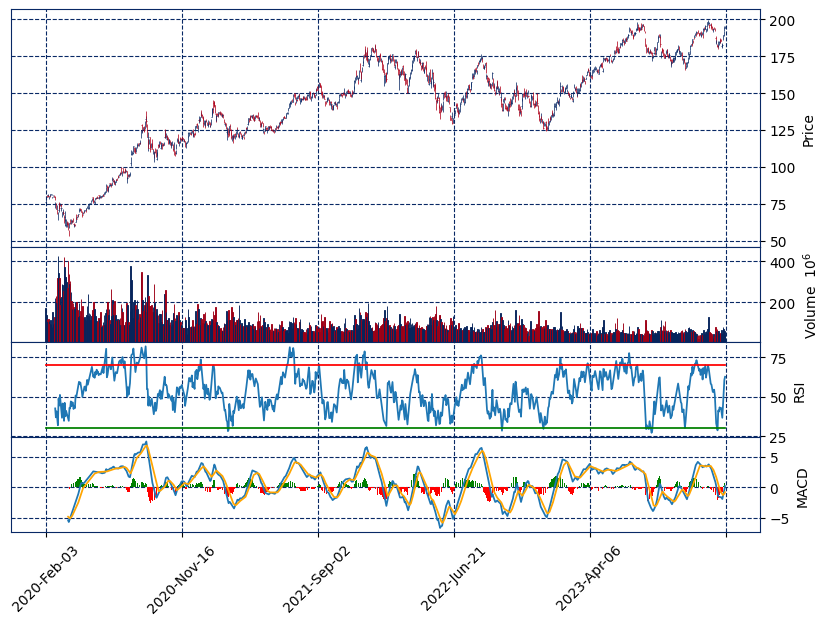

In [20]:
from stockMarket.core import Contract

contract = Contract(ticker="AAPL")
contract.init_pricing_data()
rsi = contract.rsi()
macd = contract.macd()
contract.plot(rsi=rsi, macd=macd)
